

### **Домашнее задание**
В этом задании вам предстоит обучить свой собственный классификатор биологического гендера человека по аудиозаписи (спектрограмме). На [семинаре](https://vk.cc/atRKR8) 9 мая мы разобрали, как построить спектрограмму и подать ее в нейросеть, а также написали бейзлайн решение на Keras. 

### Задание 1 (20% баллов)
Взяв данные с семинара из датасета TIMIT (библиотека для работы с ним и подготовки данных также есть в семинаре) натренировать сетку так, чтобы на тестовой выборке accuracy_score был больше 0.97. Возможные исследования: conv1d vs conv2d, batch norm, предобученные сетки из `Imagenet`. Обязательно напишите, что вы использовали и какой вывод. Писать можно на любом фреймворке. 
### Задание 2 (30% баллов)
Подумайте, как бы можно было "испортить" данные для тестовой выборки и впоследствии попробовать восстановить скор при помощи аугментаций трейнсета и усложнения архитектуры? Используя данные из `TEST` усложните выборку и посмотрите, как упадет accuracy_score. Следите, чтобы он не падал ниже 70 -- есть риск тогда не обучиться совсем. Вдохновиться аудио аугментациями можно например [здесь](https://vk.cc/atRLgR). Почитать про то, как еще аугментируют данные, но уже на уровне спектрограмм можно [в блоге Google AI](https://vk.cc/9jCCnk). Посмотрите, какие аугментации влияют сильнее всего? На этом этапе мы пока ничего не учим, а только пытаемся испортить скор бейзлайна с семинара.
### Задание 3 (40% баллов)
При помощи изложенных в предыдущем пункте средств, а также идей и хинтов с семинара, постарайтесь улучшить скор модели на "испорченных" данных. Можно делать все, кроме обучения на тесте :). 
### Задание 4 (10% баллов)
Напишите вывод -- если попробовали какие-то архитектуры, аугментации, но это не помогло, тоже обязательно напишите. Расскажите, что пробовали, и что оказалось самым боевым. Здесь будет релевантно сделать таблицу.

Дополнительные материалы и ссылки:
1. [Текстом про то, как делается преобразование в мел-спектрограмму](https://medium.com/@jonathan_hui/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9)
2. [Соревнование по классификации голосовых команд](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)
3. [Данные для распознавания речи на русском языке](https://github.com/snakers4/open_stt)
4. [Проект по генерации музыки](https://openai.com/blog/jukebox/)
5. [Опенсорс-проект по разделению песни на минус и вокал](https://github.com/deezer/spleeter)
6. [wav2vec](https://arxiv.org/abs/1904.05862)
7. [Лекция 
Microsoft Research
 про историю Automatic Speech Recognition](https://www.youtube.com/watch?v=q67z7PTGRi8)
8. [Transformer для генерации музыки](https://openai.com/blog/musenet/)
9. [Библиотека, содержащая в себе api для распознавания речи (Google, Microsoft, ...)](https://pypi.org/project/SpeechRecognition/)

In [18]:
# !pip3 install librosa

    100% |████████████████████████████████| 1.6MB 602kB/s 
    100% |████████████████████████████████| 20.1MB 58kB/s 
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 26.1MB 44kB/s 
    100% |████████████████████████████████| 6.9MB 174kB/s 
    100% |████████████████████████████████| 307kB 1.8MB/s 
    100% |████████████████████████████████| 327kB 2.4MB/s 
    100% |████████████████████████████████| 2.6MB 427kB/s 
    100% |████████████████████████████████| 20.2MB 55kB/s 
    100% |████████████████████████████████| 583kB 462kB/s 
    100% |████████████████████████████████| 399kB 664kB/s 
    100% |████████████████████████████████| 112kB 3.7MB/s 
  Running setup.py bdist_wheel for librosa ... done
  Stored in directory: /home/care1e55/.cache/pip/wheels/4c/6e/d7/bb93911540d2d1e44d690a1561871e5b6af82b69e80938abef
  Running setup.py bdist_wheel for audioread ... done
  Stored in directory: /home/care1e55/.cache/pip/wheels/b9/64/09/0b6417df9d8b

In [1]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm, tqdm_notebook
import joblib as jl
import os

import matplotlib.pyplot as plt
import IPython # прослушивание аудио в ноутбуке
import numpy as np # отсюда возьмем Фурье
import librosa # множественные манипуляции с аудиофайлами 
import tensorflow.keras, tensorflow.keras.layers

%matplotlib inline

import torch
from sklearn.metrics import accuracy_score

%matplotlib inline
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du
import os
import math
import skimage

import tensorflow.keras, tensorflow.keras.layers

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# ref1 = librosa.feature.melspectrogram(amplitudes2, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)

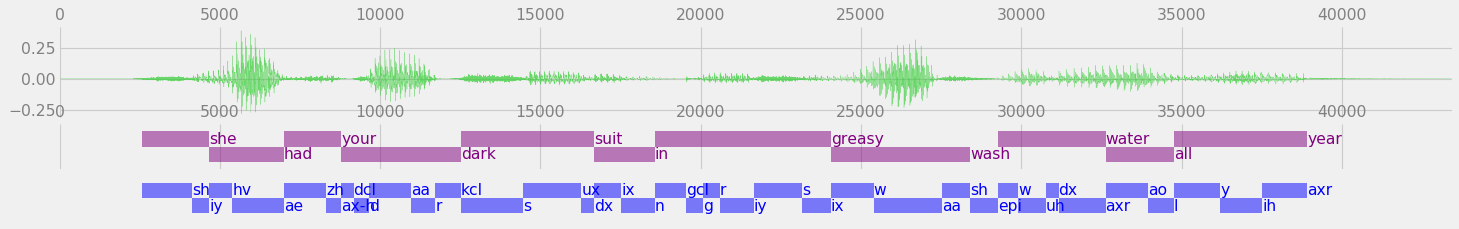

In [3]:
DATA_PATH = '/storage/Study/neuro2/hw6/data/lisa/data/timit/raw/TIMIT'
corpus = tu.Corpus(DATA_PATH)
sentence = corpus.train.sentences_by_phone_df('aa').sentence[0]
du.DrawVerticalPanels([du.AudioPanel(sentence.raw_audio, show_x_axis=True),
                       du.WordsPanel(sentence.words_df, sentence.raw_audio.shape[0], show_x_axis=True),
                       du.PhonesPanel(sentence.phones_df, sentence.raw_audio.shape[0])
                      ])

In [4]:
class Speaker:

  def __init__(self, data_path):
    self.doc_file_path = os.path.join(data_path, 'DOC','SPKRINFO.TXT')
    with open(self.doc_file_path) as f:
      self.id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])

  def return_sex(self, id):
    return self.id_sex_dict[id]

Speakers_info = Speaker(DATA_PATH)

In [5]:
def preprocess_sample(amplitudes, gender, sr=16000, max_length=150):
    # spectrogram = get_melspectrogram(amplitudes, sample_rate=sr)[:, :max_length]
    # ref1 = librosa.feature.melspectrogram(amplitudes2, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
    
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = 0 if gender == 'F' else 1
    return np.float32(spectrogram), np.int64(target)

In [6]:
def create_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(person.sentence_by_index(i).raw_audio, target))
  return spectrograms_and_targets

In [7]:
trainset = create_dataset('train')

In [8]:
X, y = map(np.stack, zip(*trainset))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

In [9]:
X.shape

(4000, 150, 128)

In [10]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

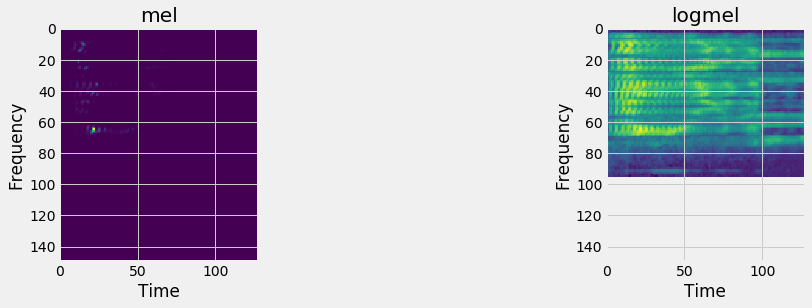

In [11]:
plt.figure(figsize=[16, 4])
plt.subplot(1, 2, 1)
plt.title("mel"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(X[5])

plt.subplot(1, 2, 2)
plt.title("logmel"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(np.log(X[5]));

In [12]:
import cv2

In [13]:
from skimage import io

In [14]:
def spectrogram_image(X, y):
    skimage.io.imsave(out, img)

(150, 128, 3)


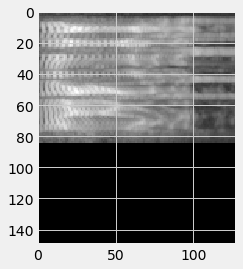

In [15]:
io.imsave('out.png', scale_minmax(np.log(X[0] + 1e-9), 0, 255).astype(np.uint8))
out = cv2.imread('out.png', 0)
out = cv2.cvtColor(out,cv2.COLOR_GRAY2RGB)

print(out.shape)
plt.imshow(out)

In [16]:
def melspec_to_rgbimg(X):
    X_img = []
    for img in np.log(X + 1e-9):
        io.imsave('buff.png', img.astype(np.uint8))
        out = cv2.imread('buff.png', 0)
        out = cv2.cvtColor(out,cv2.COLOR_GRAY2RGB)
        X_img.append(out)
    return np.array(X_img)

In [17]:
trainset = create_dataset('train')
X, y = map(np.stack, zip(*trainset))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]
X_img = melspec_to_rgbimg(X)
X_train, X_val, y_train, y_val = train_test_split(X_img, y, random_state=42)

In [18]:
from tensorflow.keras.applications import ResNet50

In [19]:
import tensorflow.keras, tensorflow.keras.layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50


# model = tensorflow.keras.models.Sequential([
#     tensorflow.keras.layers.InputLayer(input_shape=(None, 128)), 
#     tensorflow.keras.layers.Conv1D(32, kernel_size=4), tensorflow.keras.layers.Activation('relu'),
#     tensorflow.keras.layers.BatchNormalization(),
#     tensorflow.keras.layers.Conv1D(64, kernel_size=4), tensorflow.keras.layers.Activation('relu'),
#     tensorflow.keras.layers.BatchNormalization(),
#     tensorflow.keras.layers.Conv1D(128, kernel_size=4), tensorflow.keras.layers.Activation('relu'),
#     tensorflow.keras.layers.BatchNormalization(),
#     tensorflow.keras.layers.Conv1D(256, kernel_size=4), tensorflow.keras.layers.Activation('relu'),
#     tensorflow.keras.layers.BatchNormalization(),
# tensorflow.keras.layers.Conv1D(512, kernel_size=4), tensorflow.keras.layers.Activation('relu'),
#     tensorflow.keras.layers.BatchNormalization(),

#     tensorflow.keras.layers.GlobalAveragePooling1D(),
#     tensorflow.keras.layers.Dense(2, activation='softmax')
# ])
# model.summary()

base_model = ResNet50(
    include_top = False, 
    pooling = 'avg', 
    weights='imagenet', 
    ) 

model = tensorflow.keras.models.Sequential([
    base_model,
    tensorflow.keras.layers.Dense(1024, activation='relu'),
    tensorflow.keras.layers.Dropout(0.5),
    tensorflow.keras.layers.Dense(2, 
    activation='softmax'
    )
])

# for l in base_model.layers:
#     l.trainable=False

# for l in base_model.layers[10:]:
#     l.trainable=True

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 25,687,938
Trainable params: 25,634,818
Non-trainable params: 53,120
_________________________________________________________________


In [20]:
print(X_train.shape)
print(y_train.shape)

(3000, 150, 128, 3)
(3000,)


In [21]:
optimizer = tensorflow.optimizers.Adam(lr=0.0002)
save_model = ModelCheckpoint('model.h5',monitor='sparse_categorical_accuracy',save_best_only=True,mode='max')
stop_model = EarlyStopping(monitor='val_sparse_categorical_accuracy',mode='max',patience=3)
def lr_scheduler(epoch):
    drop = 0.85
    epochs_drop = 2
    lrate = 0.00001 * math.pow(drop, math.floor((epoch)/epochs_drop))
    # lrate = 0.02 * drop
    return lrate
lrate = LearningRateScheduler(lr_scheduler)

In [22]:
print(tensorflow.__version__)

2.1.0


In [23]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tensorflow.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [24]:
tensorflow.test.is_gpu_available() # True/False

# Or only check for gpu's with cuda support
tensorflow.test.is_gpu_available(cuda_only=True) 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [25]:
model.compile(  optimizer=optimizer, 
                # loss = 'sparse_categorical_crossentropy',
                # metrics = ['sparse_categorical_accuracy']
                loss = 'sparse_categorical_crossentropy',
                metrics = ['sparse_categorical_accuracy']
                
                )

history = model.fit(
                    X_train, 
                    y_train, 
                    batch_size=8,
                    epochs=30,
                    validation_data = [X_val, y_val], 
                    callbacks = [
                        lrate, 
                        save_model, 
                        stop_model
                        ]) 

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 70s 23ms/sample - loss: 0.4377 - sparse_categorical_accuracy: 0.7997 - val_loss: 0.4166 - val_sparse_categorical_accuracy: 0.8000
Epoch 2/30
3000/3000 [==============================] - 59s 20ms/sample - loss: 0.1774 - sparse_categorical_accuracy: 0.9307 - val_loss: 0.1013 - val_sparse_categorical_accuracy: 0.9640
Epoch 3/30
3000/3000 [==============================] - 60s 20ms/sample - loss: 0.1143 - sparse_categorical_accuracy: 0.9567 - val_loss: 0.0966 - val_sparse_categorical_accuracy: 0.9640
Epoch 4/30
3000/3000 [==============================] - 60s 20ms/sample - loss: 0.0781 - sparse_categorical_accuracy: 0.9730 - val_loss: 0.0896 - val_sparse_categorical_accuracy: 0.9680
Epoch 5/30
3000/3000 [==============================] - 60s 20ms/sample - loss: 0.0587 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.1794 - val_sparse_categorical_accuracy: 0.9190
Epoch 6/30
3000/3000 [

In [26]:
# model.load_weights('model.h5')

In [27]:
for l in model.layers:
    l.trainable=False

In [28]:
testset = create_dataset('test')
X_test, y_test = map(np.stack, zip(*testset))
X_test = X_test.transpose([0, 2, 1])  # to [batch, time, channels]
X_test = melspec_to_rgbimg(X_test)

In [29]:
y_pred = model.predict_classes(X_test)
accuracy_score(y_pred, y_test)

0.976

In [30]:
def spoil_with_noise(data, noise_factor=0.02):
    noise = np.random.normal(size=len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [31]:
def speed_change(data, speed_factor=0.5):
  return librosa.effects.time_stretch(data, speed_factor)

In [32]:
def pitch(data, sampling_rate=16000, pitch_factor=4):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [33]:
def spoil_dataset(mode='train', spoil_method='noise'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  if spoil_method == 'noise':
      spoil = spoil_with_noise
  if spoil_method == 'speed':
      spoil = speed_change
  if spoil_method == 'pitch':
      spoil = pitch
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(spoil(person.sentence_by_index(i).raw_audio),target))
  return spectrograms_and_targets

In [34]:
testset_noise = spoil_dataset(mode='test', spoil_method='noise')
testset_speed = spoil_dataset(mode='test', spoil_method='speed')
testset_pitch = spoil_dataset(mode='test', spoil_method='pitch')

In [35]:
testset_pitch = spoil_dataset(mode='test', spoil_method='pitch')
X_test_pitch, y_test_pitch = map(np.stack, zip(*testset_pitch))
X_test_pitch = X_test_pitch.transpose([0, 2, 1])  # to [batch, time, channels]
X_test_pitch = melspec_to_rgbimg(X_test_pitch)

In [36]:
testset_speed = spoil_dataset(mode='test', spoil_method='speed')
X_test_speed, y_test_speed = map(np.stack, zip(*testset_speed))
X_test_speed = X_test_speed.transpose([0, 2, 1])  # to [batch, time, channels]
X_test_speed = melspec_to_rgbimg(X_test_speed)

In [37]:
testset_noise = spoil_dataset(mode='test', spoil_method='noise')
X_test_noise, y_test_noise = map(np.stack, zip(*testset_noise))
X_test_noise = X_test_noise.transpose([0, 2, 1])  # to [batch, time, channels]
X_test_noise = melspec_to_rgbimg(X_test_noise)

In [38]:
y_pred_pitch = model.predict_classes(X_test_pitch)
print('pitch: ', accuracy_score(y_pred_pitch, y_test_pitch))

pitch:  0.648


In [39]:
y_pred_noise = model.predict_classes(X_test_noise)
print('noise: ', accuracy_score(y_pred_noise, y_test_noise))

noise:  0.8533333333333334


In [40]:
y_pred_speed = model.predict_classes(X_test_speed)
print('speed: ', accuracy_score(y_pred_speed, y_test_speed))

speed:  0.966


In [41]:
trainset_speed = spoil_dataset(mode='train', spoil_method='noise')
X, y = map(np.stack, zip(*trainset_speed))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]
X_img = melspec_to_rgbimg(X)
X_train, X_val, y_train, y_val = train_test_split(X_img, y, random_state=42)

In [42]:
import tensorflow.keras, tensorflow.keras.layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    include_top = False, 
    pooling = 'avg', 
    weights='imagenet', 
    ) 

model = tensorflow.keras.models.Sequential([
    base_model,
    tensorflow.keras.layers.Dense(1024, activation='relu'),
    tensorflow.keras.layers.Dropout(0.5),
    tensorflow.keras.layers.Dense(2, 
    activation='softmax'
    )
])

# for l in base_model.layers:
#     l.trainable=False

# for l in base_model.layers[10:]:
#     l.trainable=True

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 25,687,938
Trainable params: 25,634,818
Non-trainable params: 53,120
_________________________________________________________________


In [43]:
optimizer = tensorflow.optimizers.Adam(lr=0.0002)
save_model = ModelCheckpoint('model.h5',monitor='sparse_categorical_accuracy',save_best_only=True,mode='max')
stop_model = EarlyStopping(monitor='val_sparse_categorical_accuracy',mode='max',patience=3)
def lr_scheduler(epoch):
    drop = 0.85
    epochs_drop = 2
    lrate = 0.00001 * math.pow(drop, math.floor((epoch)/epochs_drop))
    # lrate = 0.02 * drop
    return lrate
lrate = LearningRateScheduler(lr_scheduler)

In [44]:
model.compile(  optimizer=optimizer, 
                # loss = 'sparse_categorical_crossentropy',
                # metrics = ['sparse_categorical_accuracy']
                loss = 'sparse_categorical_crossentropy',
                metrics = ['sparse_categorical_accuracy']
                
                )

history = model.fit(
                    X_train, 
                    y_train, 
                    batch_size=8,
 
                    epochs=30,                   validation_data = [X_val, y_val], 
                    callbacks = [
                        lrate, 
                        save_model, 
                        stop_model
                        ]) 

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 65s 22ms/sample - loss: 0.4683 - sparse_categorical_accuracy: 0.7717 - val_loss: 0.3487 - val_sparse_categorical_accuracy: 0.8360
Epoch 2/30
3000/3000 [==============================] - 60s 20ms/sample - loss: 0.2169 - sparse_categorical_accuracy: 0.9117 - val_loss: 0.0989 - val_sparse_categorical_accuracy: 0.9640
Epoch 3/30
3000/3000 [==============================] - 60s 20ms/sample - loss: 0.1473 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.0846 - val_sparse_categorical_accuracy: 0.9650
Epoch 4/30
3000/3000 [==============================] - 63s 21ms/sample - loss: 0.1063 - sparse_categorical_accuracy: 0.9610 - val_loss: 0.1053 - val_sparse_categorical_accuracy: 0.9630
Epoch 5/30
3000/3000 [==============================] - 61s 20ms/sample - loss: 0.0744 - sparse_categorical_accuracy: 0.9770 - val_loss: 0.0868 - val_sparse_categorical_accuracy: 0.9690
Epoch 6/30
3000/3000 [

In [45]:
for l in model.layers:
    l.trainable=False

In [46]:
testset_speed = spoil_dataset(mode='test', spoil_method='noise')
X_test_speed, y_test_speed = map(np.stack, zip(*testset_speed))
X_test_speed = X_test_speed.transpose([0, 2, 1])  # to [batch, time, channels]
X_test_speed = melspec_to_rgbimg(X_test_speed)

In [47]:
y_pred_speed = model.predict_classes(X_test_speed)
print('speed: ', accuracy_score(y_pred_speed, y_test_speed))

speed:  0.9606666666666667


Для решения задачи использовался подход transfer learning на resnet50. На вход подавались изображения которые пердварительно были получены из спектрограмм. На самом деле можно было не заморачиаться с перегоном в png и обратно, а просто добавить 2 канала zeros-like, т.к. изображение все равно ч.б. На некоторых прогонах удавалась достичь скора 0,98+
В качестве аугоментации - вызов из Librosa изменение скорости и pitch, а также noise c семинара. Pitch портит скоро сильней всего, хотя, наверное, это зависит от параметров.
модель тренировал на аугоментированых шумом данных. В итоге, несмотря на то что скорей всего модель обучилась под шум, скор приемлимый.